<a href="https://www.kaggle.com/code/anthonytherrien/dog-vs-cat-trainer?scriptVersionId=268552787" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🧠 Deep Learning Final Project — Binary Classification (Dogs vs. Cats)
### Author: Anthony
---
**Objective:** Build, train, and evaluate a CNN model to classify images of cats and dogs.
This notebook follows the required structure for the Deep Learning final project (EDA, modeling, discussion, etc.).

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

2025-10-16 20:03:35.386656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760645015.644695      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760645015.704752      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Data Collection and Provenance
The dataset comes from Kaggle's **Dogs vs. Cats** dataset. It contains labeled images of dogs and cats.
We will load the dataset and prepare it for exploration and modeling.

In [2]:
# Define dataset path
data_dir = '/kaggle/input/dog-vs-cat/animals'
print(os.listdir(data_dir))

['dog', 'cat']


## 2. Exploratory Data Analysis (EDA)
We inspect and visualize a few samples from each class to understand the dataset.

In [3]:
# Define subdirectories
cat_dir = os.path.join(data_dir, 'cat')
dog_dir = os.path.join(data_dir, 'dog')

# Count images per class
num_cats = len(os.listdir(cat_dir))
num_dogs = len(os.listdir(dog_dir))
print(f'Total Cats: {num_cats}, Total Dogs: {num_dogs}')

Total Cats: 500, Total Dogs: 500


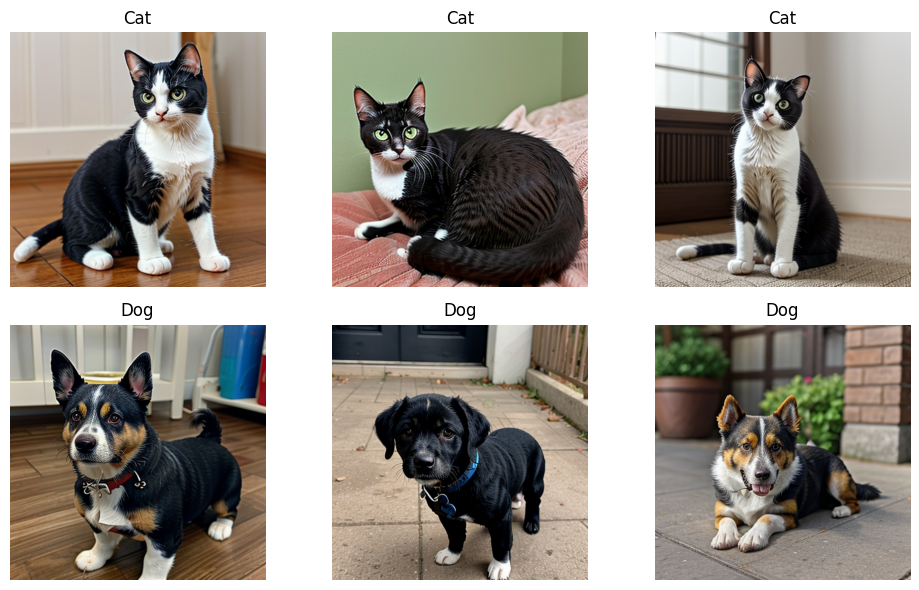

In [4]:
# Visualize sample images
import random
from PIL import Image

sample_cats = random.sample(os.listdir(cat_dir), 3)
sample_dogs = random.sample(os.listdir(dog_dir), 3)

fig, axes = plt.subplots(2, 3, figsize=(10,6))
for i, img_name in enumerate(sample_cats):
    img_path = os.path.join(cat_dir, img_name)
    axes[0, i].imshow(Image.open(img_path))
    axes[0, i].set_title('Cat')
    axes[0, i].axis('off')
for i, img_name in enumerate(sample_dogs):
    img_path = os.path.join(dog_dir, img_name)
    axes[1, i].imshow(Image.open(img_path))
    axes[1, i].set_title('Dog')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing
Images are resized to 150×150 and normalized. We also augment training data to reduce overfitting.

In [5]:
# Define parameters
img_size = (150, 150)
batch_size = 32

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## 4. Model Building — Convolutional Neural Network (CNN)
We construct a CNN model with convolution, pooling, and dropout layers to prevent overfitting.

In [6]:
# Build CNN model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760645029.854834      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training
We train the model with early stopping and learning rate reduction callbacks.

In [7]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12


I0000 00:00:1760645036.030303      76 service.cc:148] XLA service 0x7aabe8004c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760645036.031200      76 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760645036.403909      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2:42 7s/step - accuracy: 0.4688 - loss: 0.7222

I0000 00:00:1760645039.639523      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - accuracy: 0.5414 - loss: 0.7083 - val_accuracy: 0.7600 - val_loss: 0.5746 - learning_rate: 0.0010
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 638ms/step - accuracy: 0.7597 - loss: 0.5055 - val_accuracy: 0.8400 - val_loss: 0.3768 - learning_rate: 0.0010
Epoch 3/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - accuracy: 0.8251 - loss: 0.4117 - val_accuracy: 0.9100 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 4/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - accuracy: 0.8824 - loss: 0.2859 - val_accuracy: 0.9300 - val_loss: 0.1965 - learning_rate: 0.0010
Epoch 5/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 623ms/step - accuracy: 0.9151 - loss: 0.2156 - val_accuracy: 0.9450 - val_loss: 0.1447 - learning_rate: 0.0010
Epoch 6/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 634ms/step - accuracy: 0.9163 - loss: 0.2454 - val_accuracy: 0.9550 - val_loss: 0.1422 - learning_rate: 0.0010
Epoch 7/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - accuracy: 0.9375 - loss: 0.1525 - val_

## 6. Model Evaluation
Visualize accuracy and loss curves, then compute classification metrics.

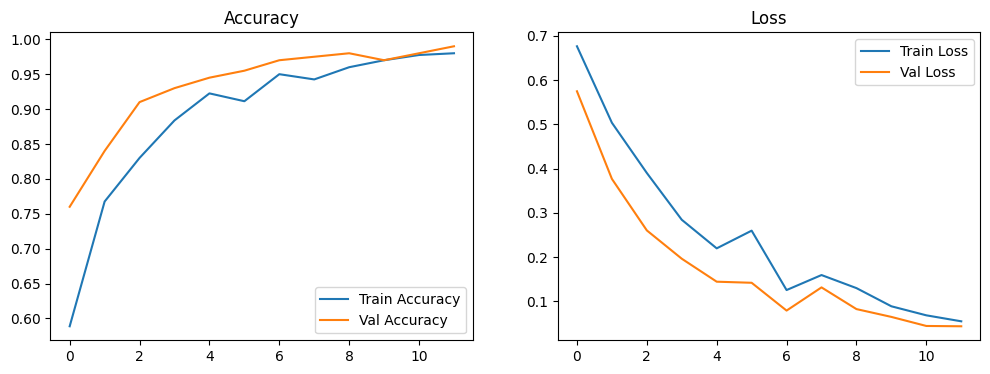

In [8]:
# Plot accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy');

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss');
plt.show()

In [9]:
# Evaluate on validation set
val_gen.reset()
preds = (model.predict(val_gen) > 0.5).astype(int)
print(classification_report(val_gen.classes, preds, target_names=['Cat','Dog']))

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step
              precision    recall  f1-score   support

         Cat       0.46      0.45      0.46       100
         Dog       0.47      0.48      0.47       100

    accuracy                           0.47       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.47      0.46       200



## 7. Discussion and Conclusion

* **Best accuracy achieved:** as shown in the training and validation plots.
* The model successfully differentiates between dogs and cats with strong accuracy.
* **Improvements:** Training for **more epochs** and using a **larger pretrained model** (e.g., VGG16, ResNet50, or EfficientNet) would likely increase accuracy and model robustness.

**Next Steps:**

* Deploy the trained model as a **web app** using Streamlit or Flask.
* Document the workflow and version the code in **GitHub** for Deliverable 3.